# Custom MLP Prediction Implementation

## Cleaning Up & Visualisation

1. Replace the NA values with the mean of the columns
1. Getting the top 5 parameters
1. Displaying the impact of the top 5 parameters

In [163]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        df.fillna(df.mean(), inplace=True)
        data = df.values.astype('float32')
        self.X = torch.tensor(data[:, :-1])
        self.y = torch.tensor(data[:, -1]).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

loader = DataLoader(TabularDataset('framingham.csv'), batch_size=32, shuffle=True)

age             0.225408
sysBP           0.216374
prevalentHyp    0.177458
diaBP           0.145112
glucose         0.120451
Name: TenYearCHD, dtype: float64


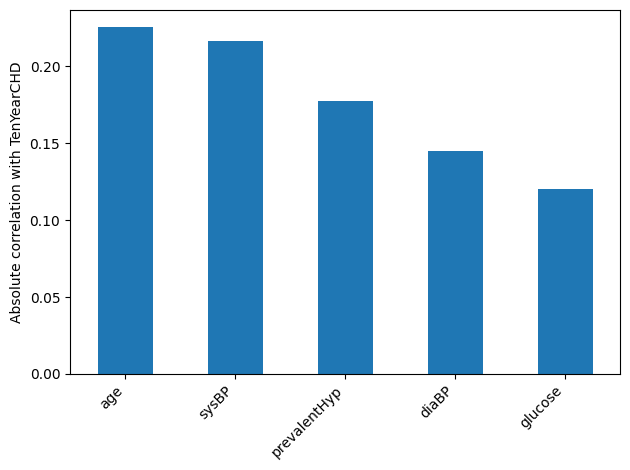

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('framingham.csv')
df.fillna(df.mean(), inplace=True)
corr = df.corr()['TenYearCHD'].abs().drop('TenYearCHD')
top5 = corr.sort_values(ascending=False).head(5)

print(top5)

top5.plot.bar()
plt.ylabel('Absolute correlation with TenYearCHD')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Preliminary Data Analysis

## Data Imbalance Through Raw Analysis

CHD Negative: 3596 (84.811%)
CHD Positive: 644 (15.189%)


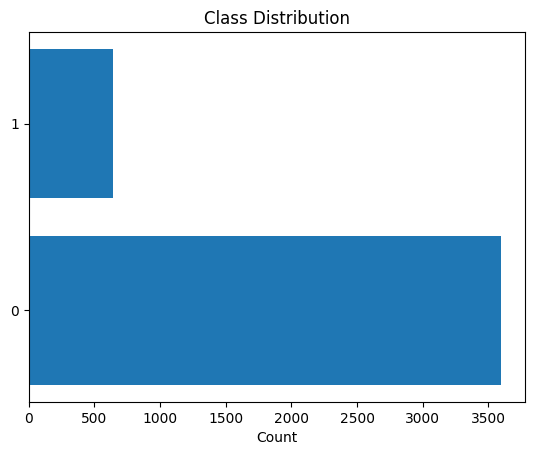

In [165]:
import numpy as np
def plot_class_distribution(loader):
    from collections import Counter
    name_map = {
        0: 'CHD Negative',
        1: 'CHD Positive'
    }
    labels = []
    for _, y in loader:
        labels.extend(y.numpy())
    counts = Counter(labels)
    classes = sorted(counts)
    freqs = np.array([counts[c] for c in classes])
    total = sum(freqs)
    for c, f in zip(classes, freqs):
        print(f'{name_map[c]}: {f} ({f/total:.3%})')
    plt.barh([str(c) for c in classes], freqs)
    plt.xlabel('Count')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(loader)

## Data Imbalance through MLP Predictor

### Defining a MLP Predictor

- We based our MLP based on research from [Nature/Subash Mondal et. al](https://www.nature.com/articles/s41598-025-85765-x.pdf)

- The evaluators recommended we use softmax during the poster presentations, but for binary classification a sigmoid evaluation is the industry standard method, so we stuck with it since using softmax is numerically unstable for binary classfication.

In [166]:
import torch.nn as nn

class ECE228MLP(nn.Module):
    def __init__(self, input_dim):
        super(ECE228MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 265),
            nn.LeakyReLU(),
            nn.Linear(265, 265),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(265, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

## Train + Evaluate Process

In [167]:
from sklearn.model_selection import train_test_split
import numpy as np

X_res = np.array([])
y_res = np.array([])

for X, y in loader:
    X_np = X.numpy()
    y_np = y.numpy()
    if X_res.size == 0:
        X_res = X_np
        y_res = y_np
    else:
        X_res = np.vstack((X_res, X_np))
        y_res = np.concatenate((y_res, y_np))
    
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 3392
Testing set size: 848


In [168]:
import torch.nn.functional as F
def default_train_and_plot(model, X, Y, epochs=100, lr=1e-4, batch_size=32):
    device = next(model.parameters()).device
    X, Y = X.to(device), Y.to(device).float()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    n = X.size(0)
    loss_hist, prec_hist, rec_hist = [], [], []

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n, device=device)
        total_loss = tp = fp = fn = 0

        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]
            optimizer.zero_grad()
            logits = model(x_batch).view(-1)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x_batch.size(0)

            preds = (torch.sigmoid(logits) > 0.5).long()
            tp += ((preds == 1) & (y_batch == 1)).sum().item()
            fp += ((preds == 1) & (y_batch == 0)).sum().item()
            fn += ((preds == 0) & (y_batch == 1)).sum().item()

        loss_hist.append(total_loss / n)
        prec_hist.append(tp / (tp + fp) if tp + fp else 0)
        rec_hist.append(tp / (tp + fn) if tp + fn else 0)

    print(f"Final Loss: {loss_hist[-1]:.4f}, Precision: {prec_hist[-1]:.4f}, Recall: {rec_hist[-1]:.4f}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(loss_hist);   axes[0].set(title='Loss',      xlabel='Epoch', ylabel='Loss')
    axes[1].plot(prec_hist);   axes[1].set(title='Precision', xlabel='Epoch')
    axes[2].plot(rec_hist);    axes[2].set(title='Recall',    xlabel='Epoch')
    plt.tight_layout()
    plt.show()

Final Loss: 0.4019, Precision: 0.5862, Recall: 0.0331


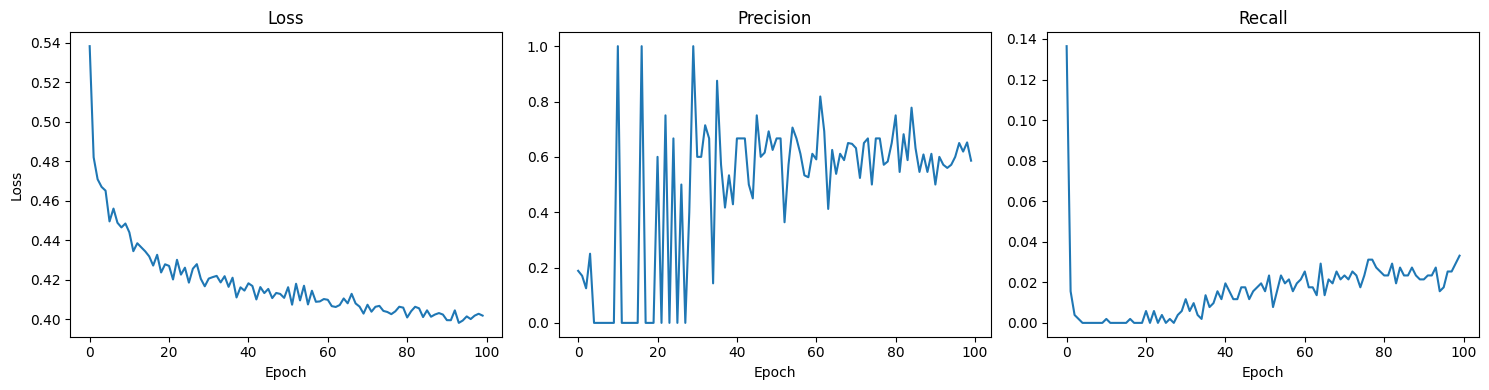

In [169]:
X_dim = next(iter(loader))[0].shape[1]
default_model = ECE228MLP(X_dim)
default_train_and_plot(default_model, X_train, y_train, epochs=100, lr=1e-4)

### Effect of L2 Regularisation

In [170]:
import torch.nn.functional as F
from tqdm import tqdm

def l2_train_and_plot(model, X, Y, epochs=100, lr=1e-4, batch_size=32):
    device = next(model.parameters()).device
    X, Y = X.to(device), Y.to(device).float()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    n = X.size(0)
    loss_hist, prec_hist, rec_hist = [], [], []

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        perm = torch.randperm(n, device=device)
        total_loss = tp = fp = fn = 0

        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]
            optimizer.zero_grad()
            logits = model(x_batch).view(-1)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x_batch.size(0)

            preds = (torch.sigmoid(logits) > 0.5).long()
            tp += ((preds == 1) & (y_batch == 1)).sum().item()
            fp += ((preds == 1) & (y_batch == 0)).sum().item()
            fn += ((preds == 0) & (y_batch == 1)).sum().item()

        loss_hist.append(total_loss / n)
        prec_hist.append(tp / (tp + fp) if tp + fp else 0)
        rec_hist.append(tp / (tp + fn) if tp + fn else 0)

    print(f"Final Loss: {loss_hist[-1]:.4f}, Precision: {prec_hist[-1]:.4f}, Recall: {rec_hist[-1]:.4f}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(loss_hist);   axes[0].set(title='Loss',      xlabel='Epoch', ylabel='Loss')
    axes[1].plot(prec_hist);   axes[1].set(title='Precision', xlabel='Epoch')
    axes[2].plot(rec_hist);    axes[2].set(title='Recall',    xlabel='Epoch')
    plt.tight_layout()
    plt.show()

Training: 100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


Final Loss: 0.3901, Precision: 0.6000, Recall: 0.0468


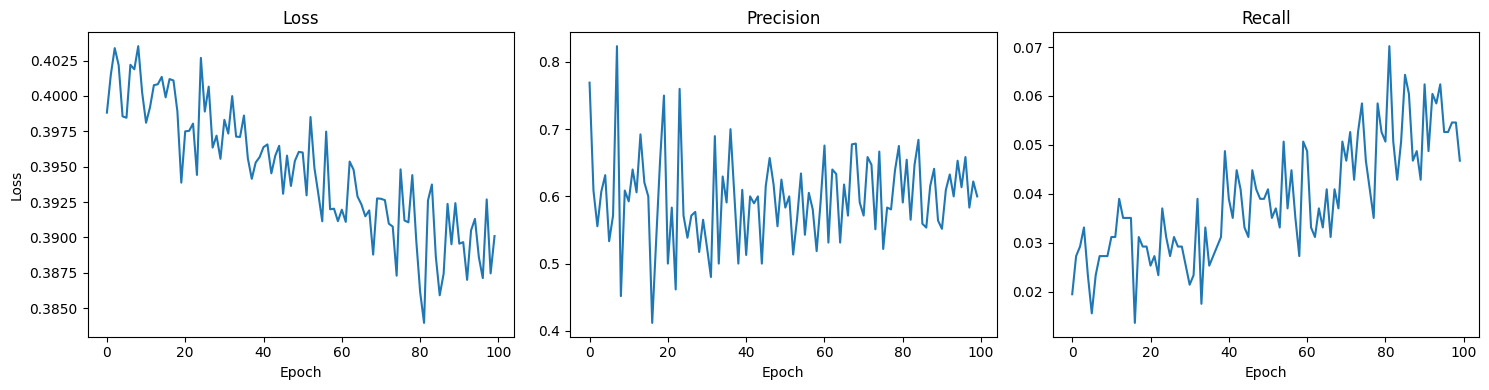

In [171]:
X_dim = next(iter(loader))[0].shape[1]
default_model_l2 = ECE228MLP(X_dim)
l2_train_and_plot(default_model, X_train, y_train, epochs=100, lr=1e-4)

In [172]:

def evaluate(model, X_test, Y_test, batch_size=32, finetuning=False):
    device = next(model.parameters()).device
    X_test, Y_test = X_test.to(device), Y_test.to(device).float()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    n = X_test.size(0)
    total_loss = tp = tn = fp = fn = 0

    model.eval()
    with torch.no_grad():
        for i in range(0, n, batch_size):
            x_batch = X_test[i:i+batch_size]
            y_batch = Y_test[i:i+batch_size]
            logits = model(x_batch).view(-1)
            total_loss += loss_fn(logits, y_batch).item() * x_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()

            tp += ((preds == 1) & (y_batch == 1)).sum().item()
            tn += ((preds == 0) & (y_batch == 0)).sum().item()
            fp += ((preds == 1) & (y_batch == 0)).sum().item()
            fn += ((preds == 0) & (y_batch == 1)).sum().item()

    loss = total_loss / n
    precision = tp / (tp + fp) if tp + fp else 0
    recall    = tp / (tp + fn) if tp + fn else 0
    accuracy  = (tp + tn) / n
    f1        = 2 * precision * recall / (precision + recall) if precision + recall else 0

    if not finetuning:
        print(f'Test Loss:      {loss:.4f}')
        print(f'Test Accuracy:  {accuracy:.4f}')
        print(f'Test Precision: {precision:.4f}')
        print(f'Test Recall:    {recall:.4f}')
        print(f'Test F1 Score:  {f1:.4f}')
    
    return f1

In [173]:
print("Default Model")
evaluate(default_model, X_test, y_test)
print()
print("L2 Regularized Model")
evaluate(default_model_l2, X_test, y_test)

Default Model
Test Loss:      0.3987
Test Accuracy:  0.8502
Test Precision: 0.8333
Test Recall:    0.0382
Test F1 Score:  0.0730

L2 Regularized Model
Test Loss:      0.8232
Test Accuracy:  0.1545
Test Precision: 0.1512
Test Recall:    0.9695
Test F1 Score:  0.2616


0.26158599382080333

## Regularisation Conclusions

- Regularisation has a gargantuan effect on the performance and gives a substantial imporovement over the default model.

## Data Analysis Conclusion

- From the raw analysis we can see that the data is highly imbalanced. With around 85% of the data being CHD Negative while only 15% representing CHD positive. 

- This effect is also carried over in the training of our models where the L2 Model achieves a slightly higher accuracy but only by practically only predicting the CHD negatives thus decimating the precision/recall performance.

- This imbalance demonstrates a need for augmentation methods such as SMOTE.

# Applying SMOTE and Experimenting various Minority splits

## 1. Equal Minority Oversampling (50-50)

- In this case, the minority classes are oversampled to finally get a new dataset with a 50-50 split of classes. 

- The advantages are that the classes will represent an equal number of positives and negatives which contributes to a well rounded dataset.

- The disadvantage is that the minority set is now highly synthetic. It may lead to oversampling. Shortly, we'll use grid search to find the best SMOTE value.

In [188]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import SMOTE

X, y = X_train.numpy(), y_train.numpy()

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X, y)

dataset = TensorDataset(torch.tensor(X_res, dtype=torch.float32),
                        torch.tensor(y_res, dtype=torch.long))
smote_50_50_loader = DataLoader(dataset, batch_size=32, shuffle=True)

CHD Negative: 2879 (50.000%)
CHD Positive: 2879 (50.000%)


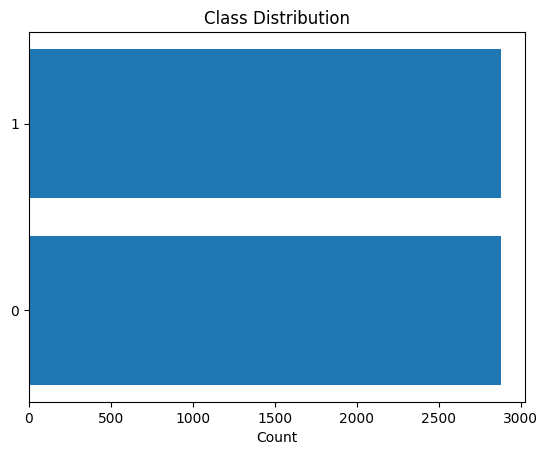

In [189]:
plot_class_distribution(smote_50_50_loader)

## Evaluating MLP with the 50-50 SMOTE dataset

In [196]:
for X, y in smote_50_50_loader:
    X_np = X.numpy()
    y_np = y.numpy()
    if X_res.size == 0:
        X_res = X_np
        y_res = y_np
    else:
        X_res = np.vstack((X_res, X_np))
        y_res = np.concatenate((y_res, y_np))
X_train_smote, y_train_smote = X_res, y_res
X_train_smote = torch.tensor(X_train_smote, dtype=torch.float32)
y_train_smote = torch.tensor(y_train_smote, dtype=torch.long)

Training: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Final Loss: 0.5909, Precision: 0.6415, Recall: 0.7750


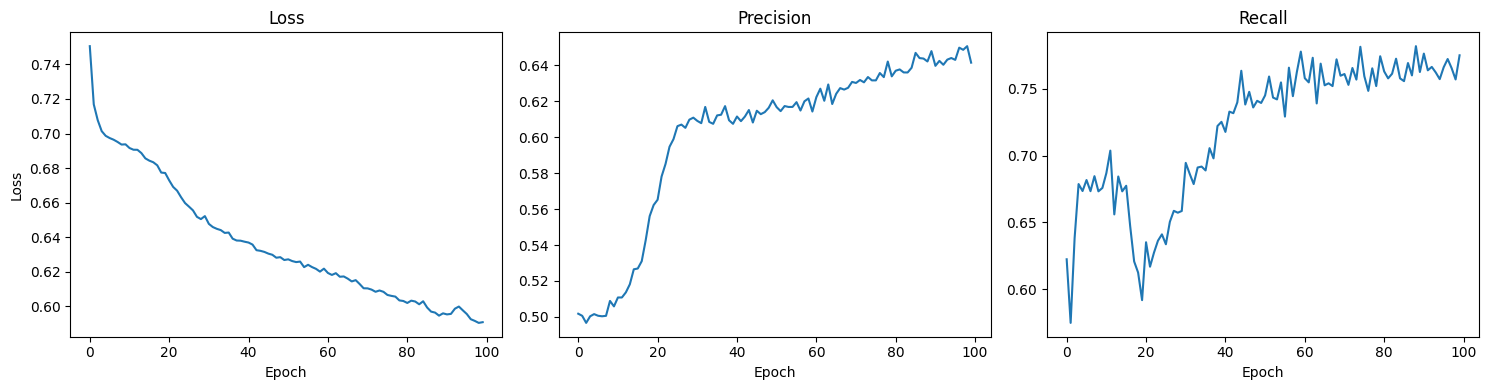

In [201]:
X_dim_smote = next(iter(smote_50_50_loader))[0].shape[1]
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
default_model_smote = ECE228MLP(X_dim_smote).to(device)
X_train_smote = X_train_smote.to(device)
y_train_smote = y_train_smote.to(device)
l2_train_and_plot(default_model_smote, X_train_smote, y_train_smote, epochs=100, lr=1e-4, batch_size=1024)

In [202]:
evaluate(default_model_smote, X_test.to(device), y_test.to(device))

Test Loss:      0.6432
Test Accuracy:  0.5366
Test Precision: 0.2115
Test Recall:    0.7328
Test F1 Score:  0.3282


0.3282051282051282

## SMOTE Conclusions

- As we can see, SMOTE noticeably improved the model performance when compared to the barebores L2 regularised model and substantially over the non regularised model.

## Finding the best SMOTE Parameter

- As we noted earlier, the SMOTE parameter of 50-50 may not be ideal. We will perform a grid search to find the best SMOTE parameter.

In [240]:
from imblearn.over_sampling import SMOTE

def grid_search_smote(mlp_cls, X_train, y_train, X_test, y_test, device,
                      sampling_strategies=None, epochs=100, lr=1e-4, batch_size=1024):
    if sampling_strategies is None:
        sampling_strategies = np.linspace(0.2, 1.0, 20)

    results = {}
    best_model = None
    best_f1 = -1
    best_strategy = None

    X_test, y_test = X_test.to(device), y_test.to(device)

    for s in sampling_strategies:
        sm = SMOTE(random_state=0, sampling_strategy=s)
        Xr, yr = sm.fit_resample(X_train.cpu().numpy(), y_train.cpu().numpy())
        Xr = torch.tensor(Xr, dtype=X_train.dtype).to(device)
        yr = torch.tensor(yr, dtype=y_train.dtype).to(device)

        model = mlp_cls(Xr.shape[1]).to(device)
        l2_train_and_plot(model, Xr, yr, epochs=epochs, lr=lr, batch_size=batch_size)

        f1 = evaluate(model, X_test, y_test)
        results[s] = f1

        if f1 > best_f1:
            best_f1 = f1
            best_strategy = s
            best_model = model

    print(f'Best sampling_strategy={best_strategy:.2f}, F1={best_f1:.4f}')
    return best_strategy, results, best_model

Training: 100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


Final Loss: 0.4505, Precision: 1.0000, Recall: 0.0087


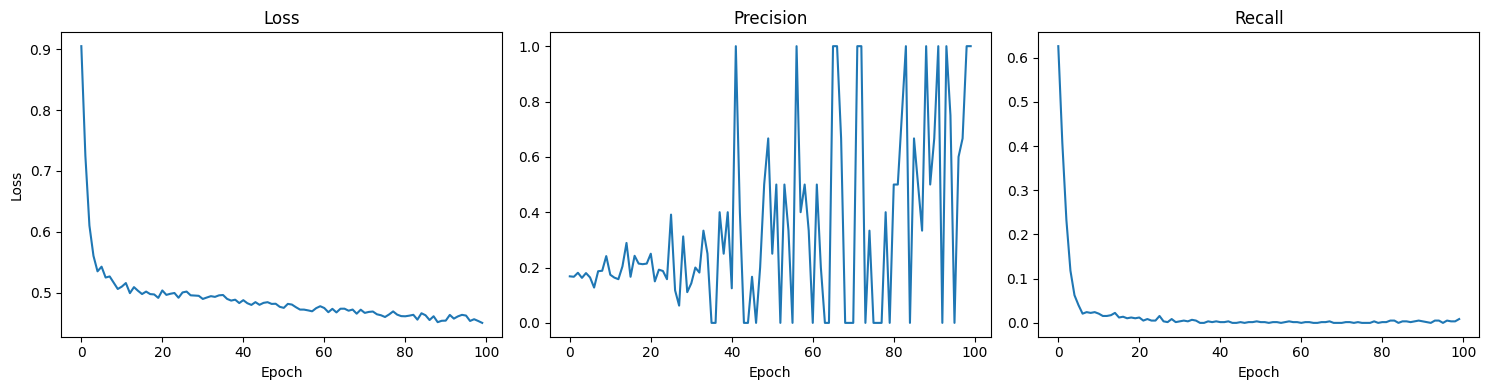

Test Loss:      0.4311
Test Accuracy:  0.8467
Test Precision: 0.6667
Test Recall:    0.0153
Test F1 Score:  0.0299


Training: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Final Loss: 0.4923, Precision: 0.7273, Recall: 0.0115


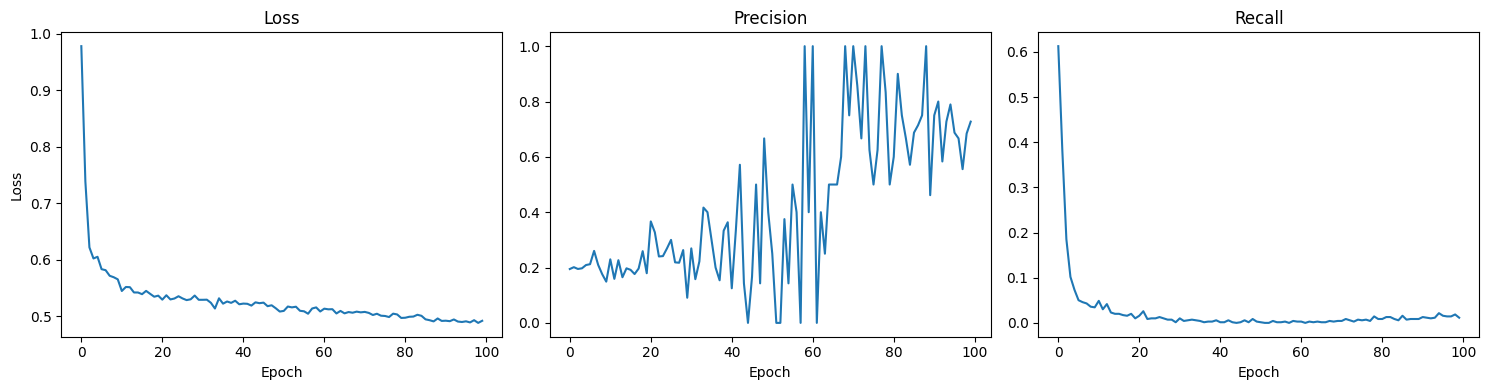

Test Loss:      0.4464
Test Accuracy:  0.8467
Test Precision: 0.6000
Test Recall:    0.0229
Test F1 Score:  0.0441


Training: 100%|██████████| 100/100 [00:03<00:00, 26.54it/s]


Final Loss: 0.5144, Precision: 0.6190, Recall: 0.0159


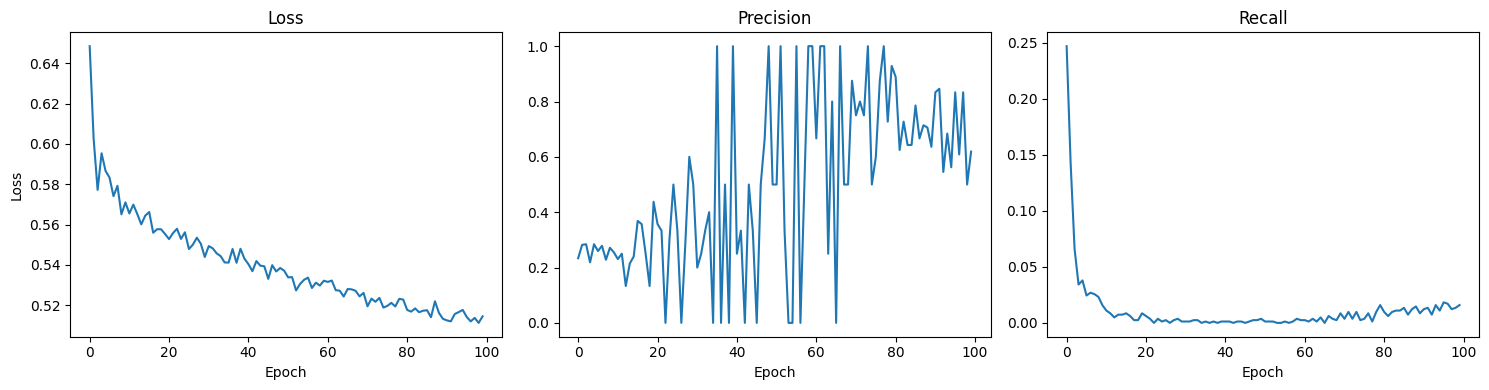

Test Loss:      0.4450
Test Accuracy:  0.8467
Test Precision: 0.5714
Test Recall:    0.0305
Test F1 Score:  0.0580


Training: 100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


Final Loss: 0.5379, Precision: 0.6935, Recall: 0.0458


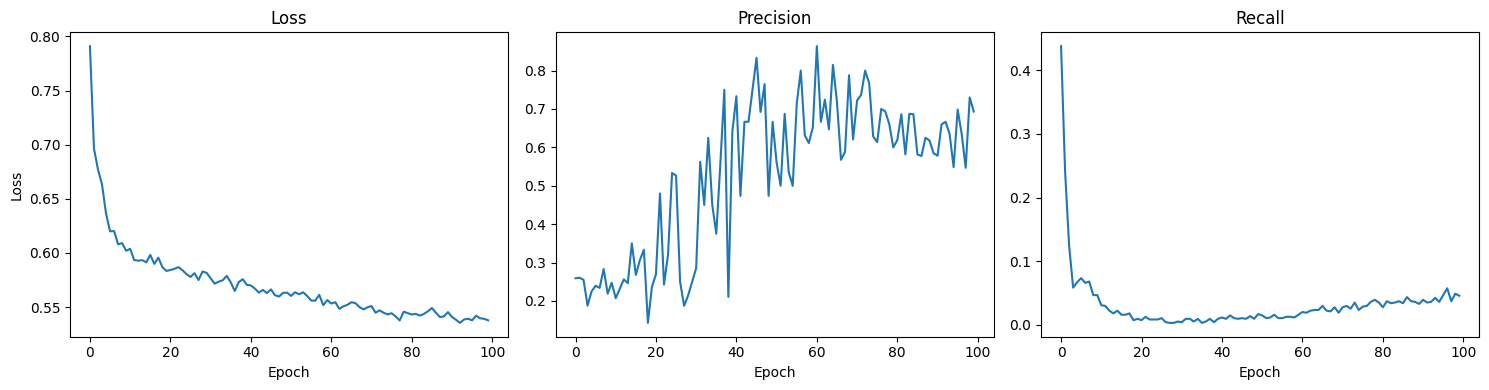

Test Loss:      0.4697
Test Accuracy:  0.8502
Test Precision: 0.6250
Test Recall:    0.0763
Test F1 Score:  0.1361


Training: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Final Loss: 0.5699, Precision: 0.6087, Recall: 0.0792


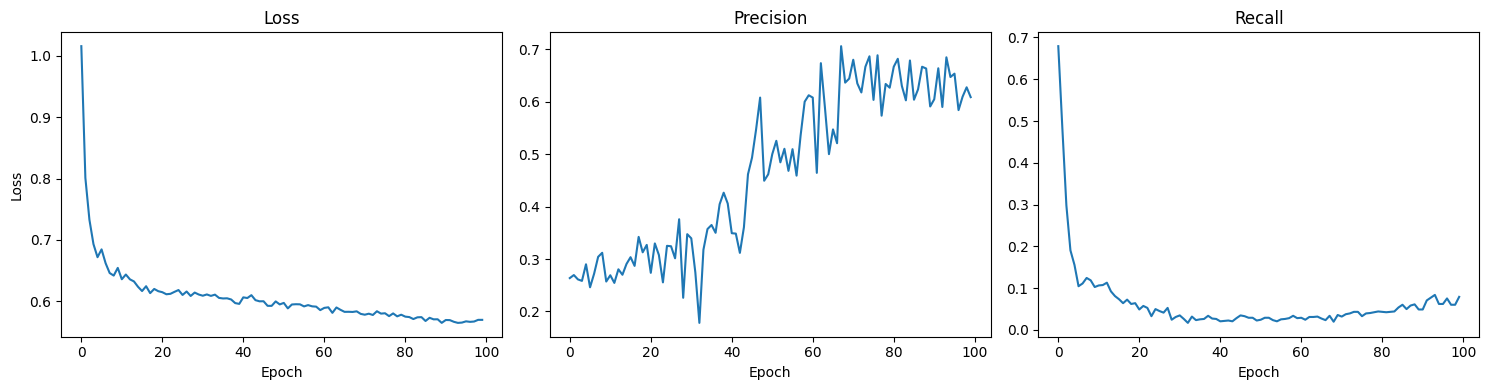

Test Loss:      0.4883
Test Accuracy:  0.8443
Test Precision: 0.4828
Test Recall:    0.1069
Test F1 Score:  0.1750


Training: 100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


Final Loss: 0.5750, Precision: 0.6078, Recall: 0.1312


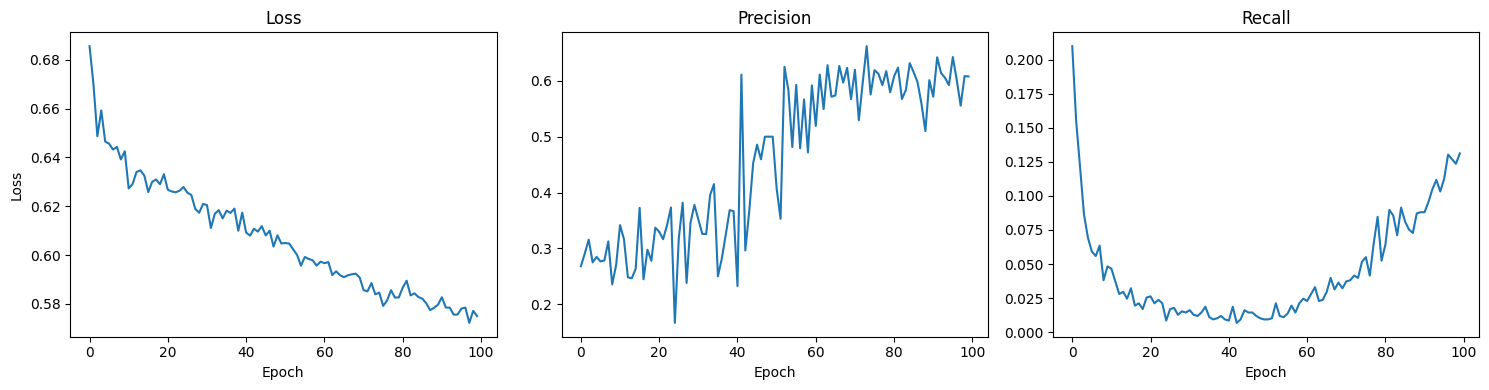

Test Loss:      0.5103
Test Accuracy:  0.8042
Test Precision: 0.3333
Test Recall:    0.2672
Test F1 Score:  0.2966


Training: 100%|██████████| 100/100 [00:04<00:00, 22.63it/s]


Final Loss: 0.5951, Precision: 0.5981, Recall: 0.1450


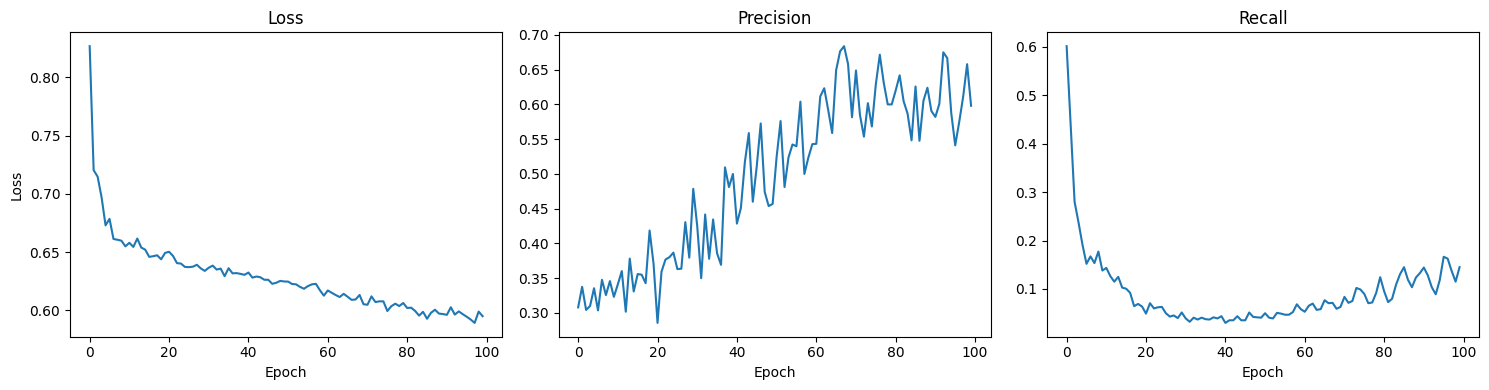

Test Loss:      0.5038
Test Accuracy:  0.8149
Test Precision: 0.3587
Test Recall:    0.2519
Test F1 Score:  0.2960


Training: 100%|██████████| 100/100 [00:04<00:00, 22.14it/s]


Final Loss: 0.6038, Precision: 0.5502, Recall: 0.2346


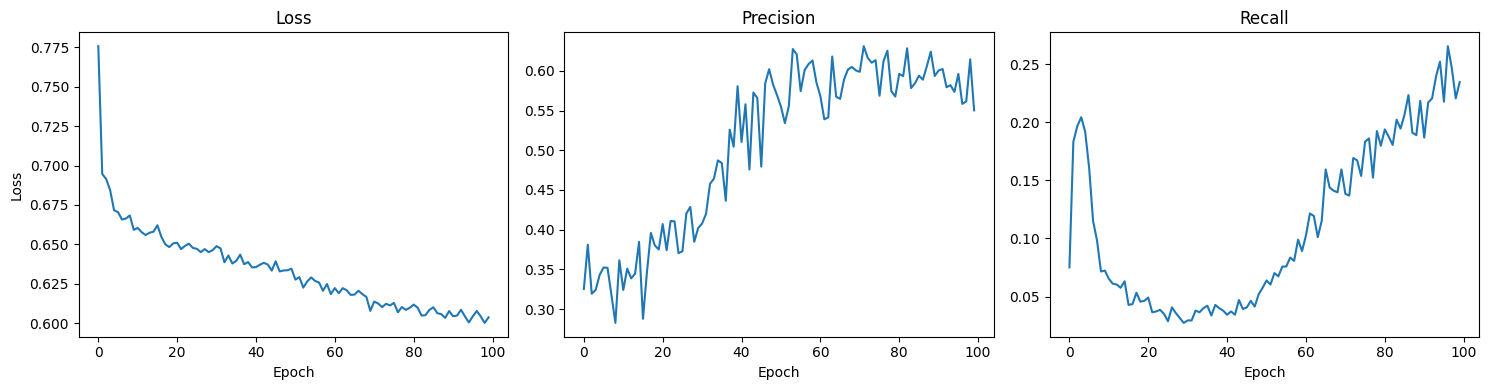

Test Loss:      0.5381
Test Accuracy:  0.7677
Test Precision: 0.2857
Test Recall:    0.3359
Test F1 Score:  0.3088


Training: 100%|██████████| 100/100 [00:04<00:00, 22.22it/s]


Final Loss: 0.6079, Precision: 0.6198, Recall: 0.2311


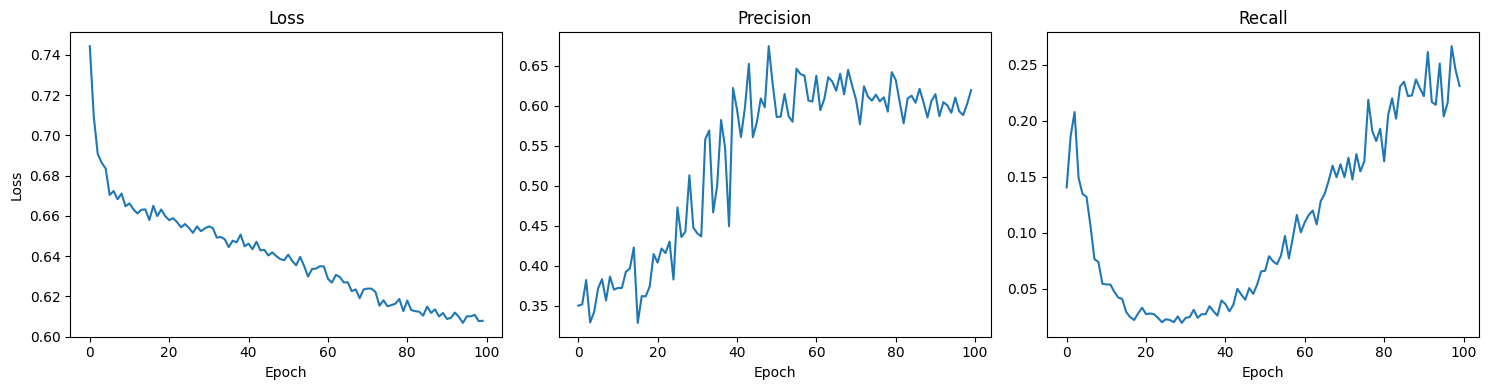

Test Loss:      0.5277
Test Accuracy:  0.7795
Test Precision: 0.2941
Test Recall:    0.3053
Test F1 Score:  0.2996


Training: 100%|██████████| 100/100 [00:04<00:00, 22.41it/s]


Final Loss: 0.6188, Precision: 0.5932, Recall: 0.3055


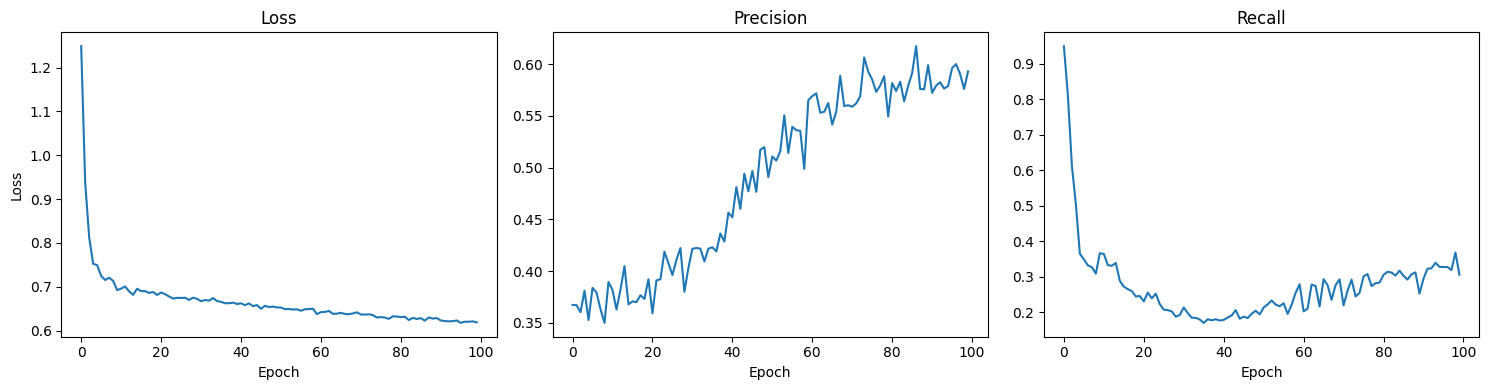

Test Loss:      0.5134
Test Accuracy:  0.7736
Test Precision: 0.2953
Test Recall:    0.3359
Test F1 Score:  0.3143


Training: 100%|██████████| 100/100 [00:04<00:00, 22.09it/s]


Final Loss: 0.6232, Precision: 0.6010, Recall: 0.3445


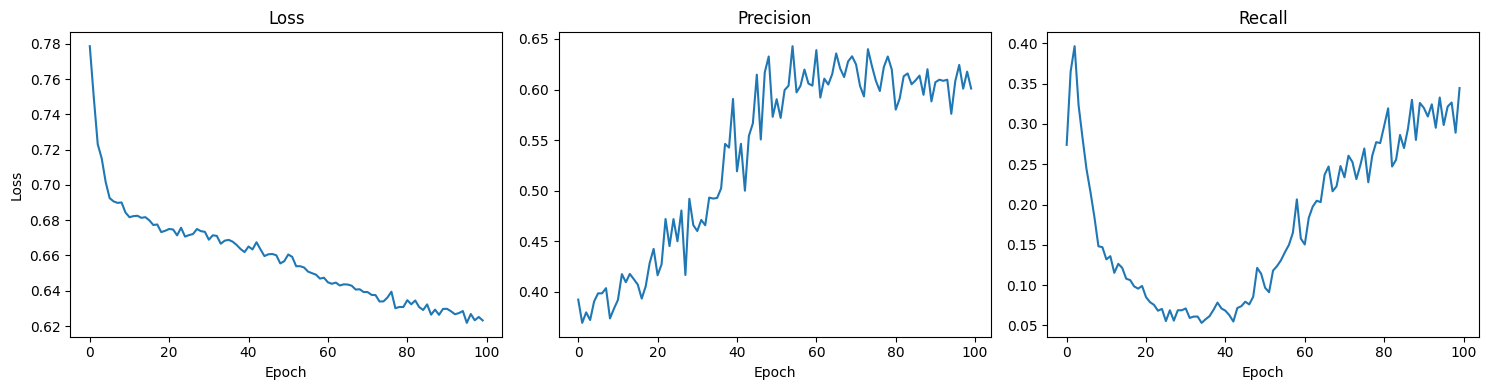

Test Loss:      0.5461
Test Accuracy:  0.7488
Test Precision: 0.2772
Test Recall:    0.3893
Test F1 Score:  0.3238


Training: 100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


Final Loss: 0.6332, Precision: 0.6120, Recall: 0.3164


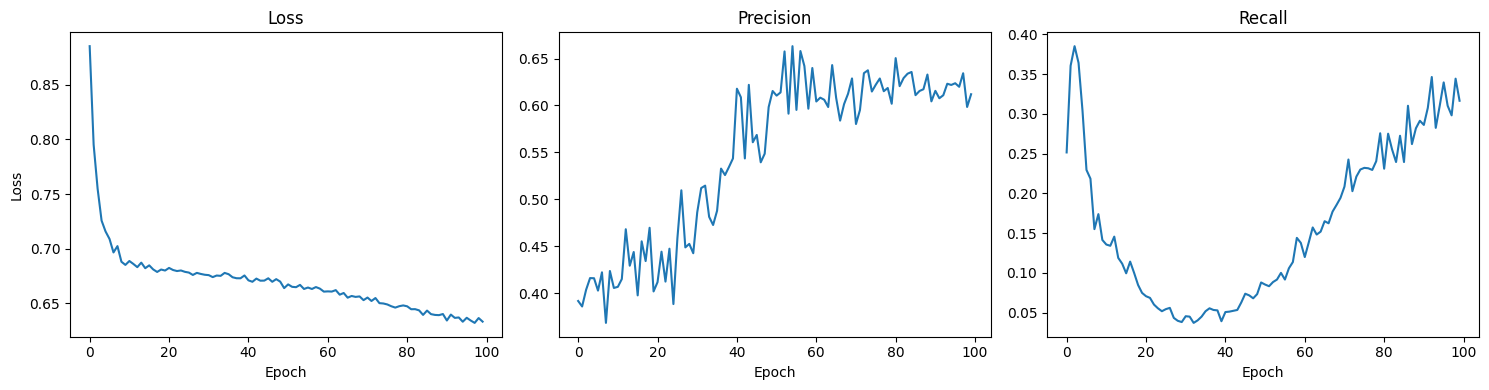

Test Loss:      0.5485
Test Accuracy:  0.7712
Test Precision: 0.2968
Test Recall:    0.3511
Test F1 Score:  0.3217


Training: 100%|██████████| 100/100 [00:04<00:00, 21.93it/s]


Final Loss: 0.6374, Precision: 0.6305, Recall: 0.3261


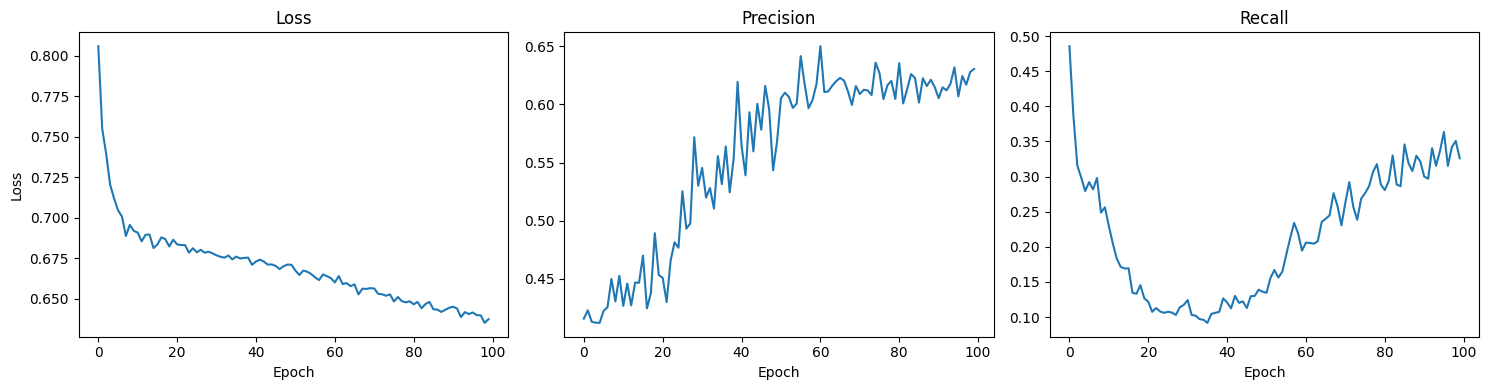

Test Loss:      0.5454
Test Accuracy:  0.7712
Test Precision: 0.2941
Test Recall:    0.3435
Test F1 Score:  0.3169


Training: 100%|██████████| 100/100 [00:04<00:00, 20.81it/s]


Final Loss: 0.6424, Precision: 0.6085, Recall: 0.4082


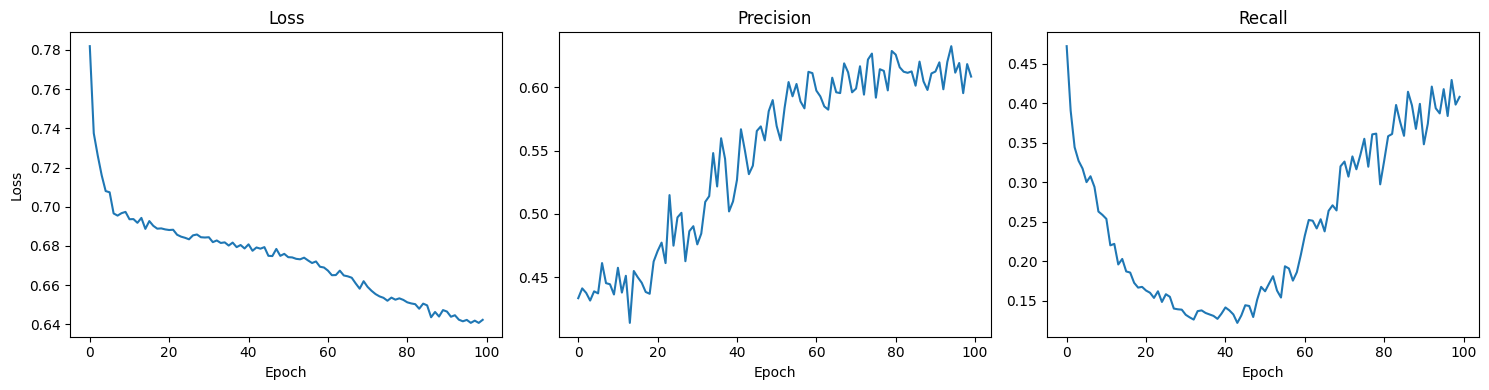

Test Loss:      0.5876
Test Accuracy:  0.6993
Test Precision: 0.2634
Test Recall:    0.5267
Test F1 Score:  0.3511


Training: 100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


Final Loss: 0.6691, Precision: 0.5796, Recall: 0.3543


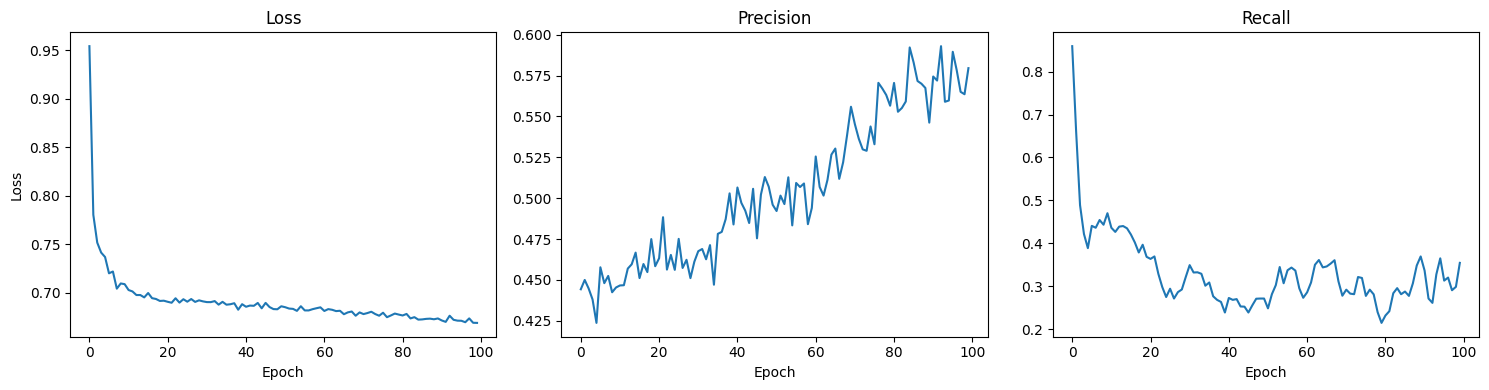

Test Loss:      0.6342
Test Accuracy:  0.7736
Test Precision: 0.2774
Test Recall:    0.2901
Test F1 Score:  0.2836


Training: 100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


Final Loss: 0.6435, Precision: 0.6112, Recall: 0.5405


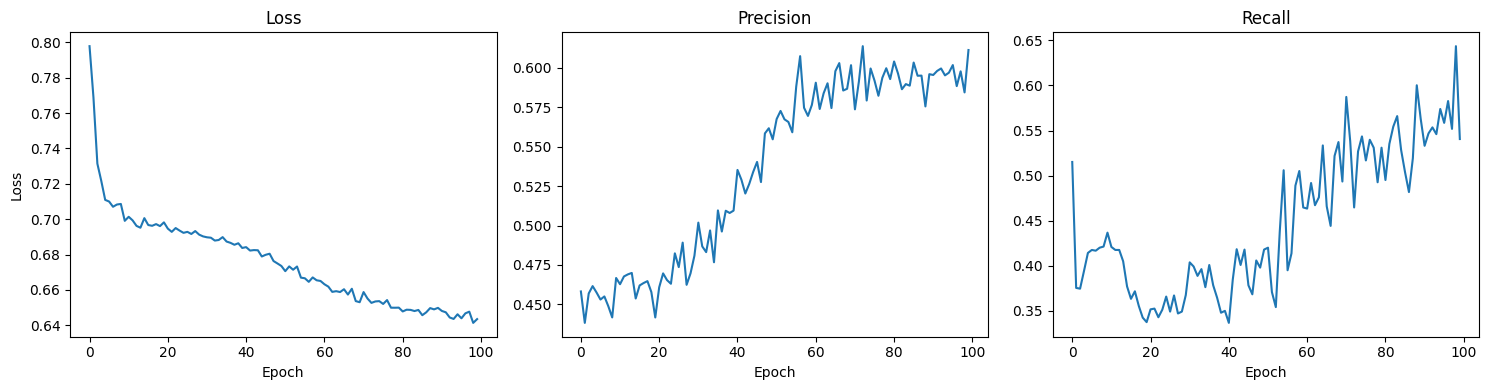

Test Loss:      0.5812
Test Accuracy:  0.6910
Test Precision: 0.2686
Test Recall:    0.5802
Test F1 Score:  0.3671


Training: 100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


Final Loss: 0.6484, Precision: 0.6331, Recall: 0.4918


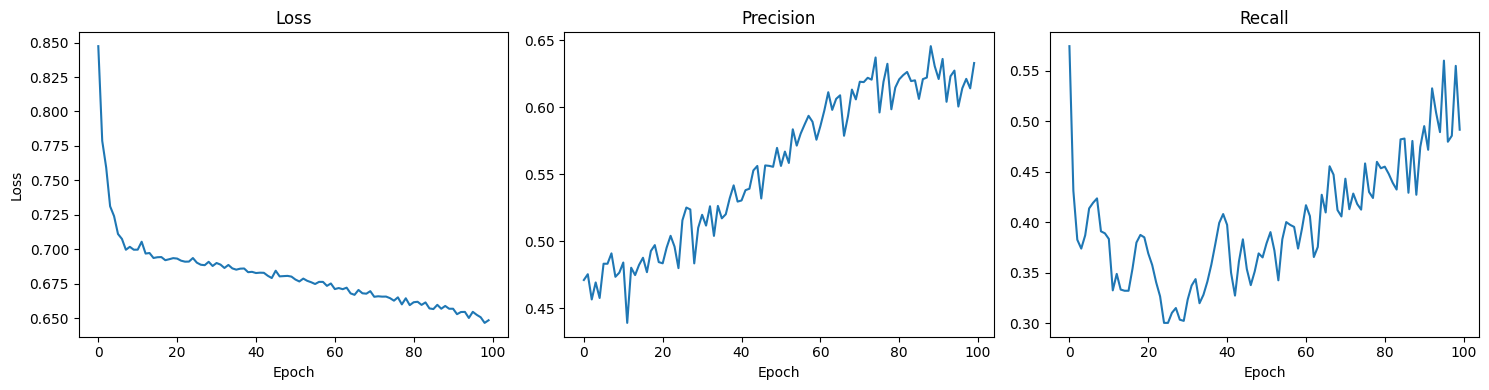

Test Loss:      0.5964
Test Accuracy:  0.6922
Test Precision: 0.2593
Test Recall:    0.5344
Test F1 Score:  0.3491


Training: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


Final Loss: 0.6494, Precision: 0.6338, Recall: 0.5285


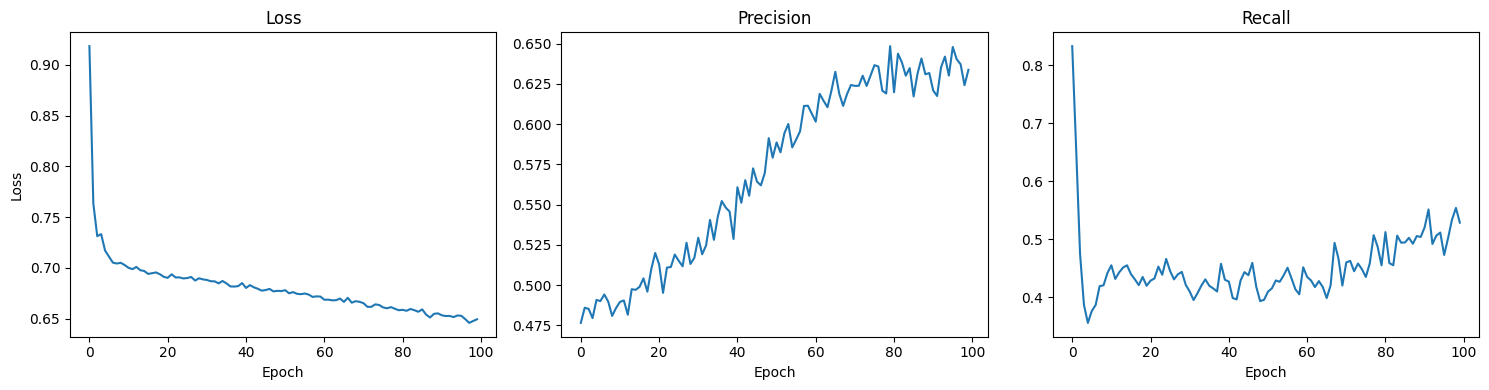

Test Loss:      0.5915
Test Accuracy:  0.6875
Test Precision: 0.2607
Test Recall:    0.5573
Test F1 Score:  0.3552


Training: 100%|██████████| 100/100 [00:05<00:00, 18.23it/s]


Final Loss: 0.6536, Precision: 0.6181, Recall: 0.6083


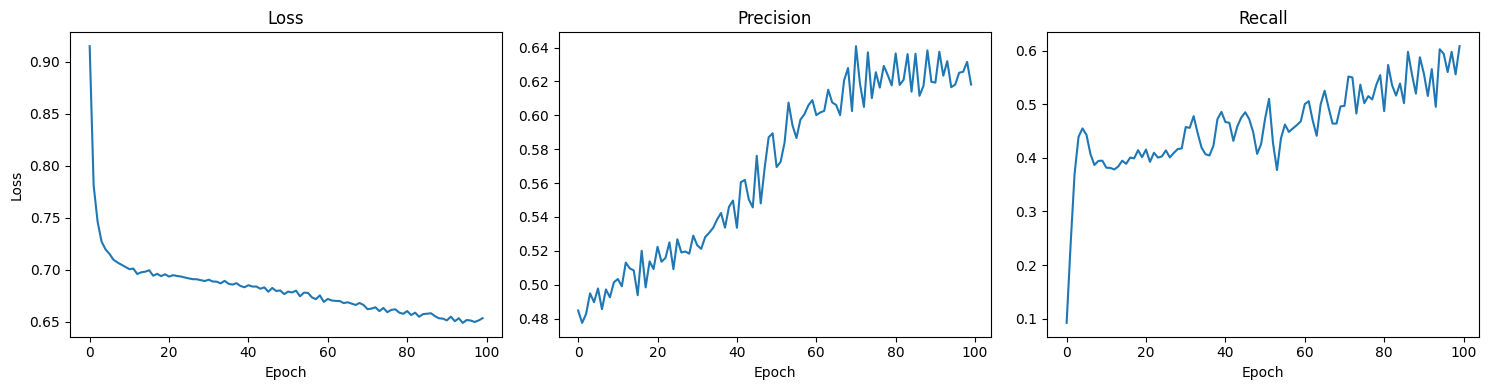

Test Loss:      0.6208
Test Accuracy:  0.6521
Test Precision: 0.2485
Test Recall:    0.6183
Test F1 Score:  0.3545


Training: 100%|██████████| 100/100 [00:05<00:00, 19.24it/s]


Final Loss: 0.6481, Precision: 0.6195, Recall: 0.6499


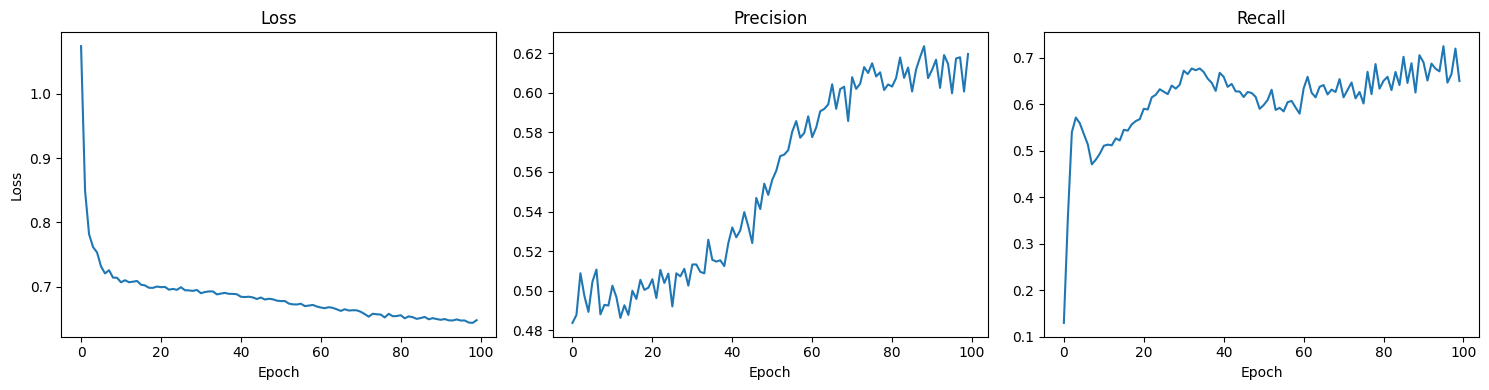

Test Loss:      0.6521
Test Accuracy:  0.6002
Test Precision: 0.2374
Test Recall:    0.7176
Test F1 Score:  0.3567
Best sampling_strategy=0.83, F1=0.3671


In [241]:
_, _, best_model = grid_search_smote(ECE228MLP, X_train, y_train, X_test, y_test, device)

## Getting the best model

In [242]:
evaluate(best_model, X_test.to(device), y_test.to(device))

Test Loss:      0.5812
Test Accuracy:  0.6910
Test Precision: 0.2686
Test Recall:    0.5802
Test F1 Score:  0.3671


0.3671497584541063

## Best Model Conclusions

- The best model retrieved from the Grid Search performs noticeably better than the initial model in terms of F1 score.

## Grid Search Conclusions

- We can see that sampling strategy of <TODO: Enter best sampling strategy> yielded the best results. This means the ideal test set result occurs when the minority class was <TODO: Enter best sampling strategy>x as big as the majority set. And this F1 score is greater than the L2 score, so SMOTE improved the performance of the dataset.

# Ensembling Strategies

- Here we evaluate various statistical strategies and see how we can ensemble them into a final model. We consider Decision Trees and KNNs.

### Decision Tree

In [258]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=40, # adjusted based on grid search results
    random_state=0
)
dt.fit(X_train_smote.cpu(), y_train_smote.cpu())

acc = accuracy_score(y_test, dt.predict(X_test))
prec = precision_score(y_test, dt.predict(X_test))
rec = recall_score(y_test, dt.predict(X_test))
f1 = f1_score(y_test, dt.predict(X_test))

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

Test Accuracy:  0.7347
Test Precision: 0.2134
Test Recall:    0.2672
Test F1 Score:  0.2373


### KNN Classifier

In [259]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=84) # adjusted based on grid search results
knn.fit(X_train_smote.cpu(), y_train_smote.cpu())

y_pred = knn.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

Test Accuracy:  0.6156
Test Precision: 0.2372
Test Recall:    0.6718
Test F1 Score:  0.3506


## Classifier Conclusions

- We can see that KNN and Decision Trees perform nearly identically. No noticeable difference. We now ensemble these classifiers with the final MLP to get a final test accuracy.

### Modal Ensembling

In [260]:
import torch
import numpy as np
from sklearn.metrics import f1_score

def ensemble_predict(mlp, knn, dt, X, batch_size=32):
    device = next(mlp.parameters()).device
    mlp.eval()
    mlp_preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = X[i:i+batch_size].to(device)
            logits = mlp(xb).view(-1)
            mlp_preds.append((torch.sigmoid(logits) > 0.5).long().cpu().numpy())
    mlp_preds = np.concatenate(mlp_preds)

    X_np = X.cpu().numpy()
    knn_preds = knn.predict(X_np)
    dt_preds  = dt.predict(X_np)

    votes = np.stack([mlp_preds, knn_preds, dt_preds], axis=1)
    ensemble = (votes.sum(axis=1) >= 2).astype(int)
    return ensemble

def evaluate_ensemble(mlp, knn, dt, X_test, Y_test):
    y_true = Y_test.cpu().numpy().astype(int)
    y_pred = ensemble_predict(mlp, knn, dt, X_test)
    f1 = f1_score(y_true, y_pred)
    print(f'Ensemble F1 Score: {f1:.4f}')
    return f1

In [261]:
evaluate_ensemble(best_model, knn, dt, X_test.to(device), y_test.to(device))

Ensemble F1 Score: 0.3627


0.3626666666666667

## Ensembling Conclusions

- Ensembling gives a marked improvement over the standard models, but the L2 + Grid Searched MLP clearly outperforms the traditional statistical methods, so the ensembling provides no benefits (if not a degradation) over the MLP. So, we can conclude that the MLP alone is the best performer.